# Baseline models

In [183]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

from lifelines import KaplanMeierFitter
from lifelines.utils import median_survival_times
from lifelines import CoxPHFitter
from lifelines.statistics import proportional_hazard_test

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import export_graphviz
import pydot

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [126]:
train_data_df = pd.read_csv('../data_analysis/scaled_train_data.csv', sep=' ')
test_data_df = pd.read_csv('../data_analysis/scaled_test_data.csv', sep=' ')

train_labels_df = pd.read_csv('../data_analysis/training_labels.csv', sep=' ')
test_labels_df = pd.read_csv('../data_analysis/testing_labels.csv', sep=' ')
test_labels_at_break_df = pd.read_csv('../TED/CMAPSSData/RUL_FD002.txt', sep=' ', header=None)

In [94]:
sensor_names = []
for i in range(3):
    sensor_names.append("OpSet" + str(i + 1))
for i in range(21):
    sensor_names.append("SensorMeasure" + str(i + 1))

## Kaplan Meier

### Adding event_observed column: 0 for not-observed (test_data), 1 for observed (train_data)

In [95]:
km_train = train_data_df.copy()
km_test = test_data_df.copy()
km_train['Event Observed'] = 1
km_test['Event Observed'] = 0

km_total = pd.concat([km_train, km_test])

<AxesSubplot:xlabel='timeline'>

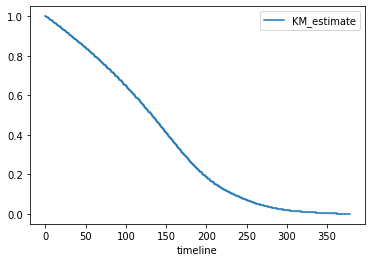

In [96]:
kmf = KaplanMeierFitter()
kmf.fit(durations = km_total['Cycle'], event_observed = km_total['Event Observed'])
kmf.plot_survival_function()

In [97]:
median_ = kmf.median_survival_time_
median_confidence_interval_ = median_survival_times(kmf.confidence_interval_)
print(median_)
print(median_confidence_interval_)

132.0
     KM_estimate_lower_0.95  KM_estimate_upper_0.95
0.5                   131.0                   133.0


## Cox Proportional Hazard

In [98]:
cox_train = train_data_df.copy()
cox_test = test_data_df.copy()
cox_train['Event Observed'] = 1
cox_test['Event Observed'] = 0

cox_total = pd.concat([cox_train, cox_test])

cox_total.drop(columns=['ID', 'OpSet1', 'OpSet2', 'OpSet3', 'SensorMeasure1', 'SensorMeasure5', 'SensorMeasure18', 'SensorMeasure19'], inplace=True)

In [99]:
cox_total

,Cycle,SensorMeasure2,SensorMeasure3,SensorMeasure4,SensorMeasure6,SensorMeasure7,SensorMeasure8,SensorMeasure9,SensorMeasure10,SensorMeasure11,SensorMeasure12,SensorMeasure13,SensorMeasure14,SensorMeasure15,SensorMeasure16,SensorMeasure17,SensorMeasure20,SensorMeasure21,Event Observed
0,1.0,-1.090341,-1.443080,0.770031,-0.174690,0.412694,-1.400815,-0.835488,-2.016377e-01,0.163636,0.097690,-1.395816,-1.531618,0.361688,3.469447e-18,-0.167404,-0.890407,-1.352348,1
1,2.0,0.450794,-0.220659,-0.264837,-1.184755,-0.274151,-1.339755,-1.328420,-1.583004e-01,0.214488,-0.380158,-1.213319,-1.040095,0.062511,3.469447e-18,-0.757098,-1.634765,-1.315594,1
2,3.0,1.242458,-1.122073,-0.421669,-1.856228,0.634449,-1.165851,-0.998547,8.908147e-02,-0.534250,-1.024452,-1.024524,-1.042345,-0.459720,0.000000e+00,1.277815,-1.631373,1.720463,1
3,4.0,-0.450245,-0.076871,-0.186270,-1.184755,-0.388018,-1.306391,-1.328420,-1.583004e-01,-0.790603,0.500487,-1.367973,-1.261000,-0.593229,3.469447e-18,-1.466987,0.033181,1.845375,1
4,5.0,0.572265,-0.942156,-0.351169,0.535646,-0.839728,-1.203979,-1.579438,8.908147e-02,0.425103,-0.762651,-1.132672,-1.321497,-0.408803,0.000000e+00,1.277815,-1.185251,-0.451156,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33986,119.0,-0.298099,0.168075,0.034749,-0.073951,0.757045,1.421872,1.382744,-2.087679e-01,0.285800,-0.123170,1.619067,1.881090,0.032130,0.000000e+00,0.118944,0.844665,-0.047158,0
33987,120.0,-0.428298,-0.367513,-0.235698,0.987232,-0.791071,1.310329,1.419192,-7.543590e-02,-0.381368,0.457158,1.412368,2.066989,-0.334369,0.000000e+00,1.130022,-0.279548,0.736105,0
33988,121.0,0.188271,-0.773918,-1.045246,0.987232,-0.956544,1.798195,1.570653,-7.543590e-02,0.432409,1.137582,1.548169,1.175502,0.596245,0.000000e+00,0.289663,-0.279548,1.897734,0
33989,122.0,0.097966,0.171007,0.323573,0.160956,-0.725250,-0.537023,1.512874,-2.220446e-16,0.080135,1.066403,-1.416628,2.124189,-0.083000,-6.938894e-18,0.201049,1.444373,0.429979,0


In [100]:
cph = CoxPHFitter()
cph.fit(cox_total, duration_col = 'Cycle', event_col = 'Event Observed')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 87750 total observations, 33991 right-censored observations>
             duration col = 'Cycle'
                event col = 'Event Observed'
      baseline estimation = breslow
   number of observations = 87750
number of events observed = 53759
   partial log-likelihood = -530317.68
         time fit was run = 2022-07-09 14:27:18 UTC

---
                  coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                               
SensorMeasure2   -0.09       0.92       0.01            -0.10            -0.08                 0.91                 0.93
SensorMeasure3   -0.06       0.94       0.01            -0.07            -0.05                 0.93                 0.95
SensorMeasure4   -0.16       0.85       0.01            -0.18            -0.15                 0.84                 0.86
SensorMeasure6   -0.05       0.95       0.01            -0.06            -0.04                 0.94                 0.96
SensorMeasure7    0.04       1.04       0.01             0.03             0.05                 1.03                 1.06
SensorMeasure8   -0.00       1.00       0.01            -0.03             0.02                 0.97                 1.02
SensorMeasure9   -0.28       0.75       0.01            -0.31            -0.26                 0.73                 0.77
SensorMeasure10   0.03       1.03       0.01             0.01             0.04                 1.01                 1.04
SensorMeasure11  -0.26       0.77       0.01            -0.28            -0.25                 0.76                 0.78
SensorMeasure12   0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
SensorMeasure13   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
SensorMeasure14  -0.28       0.76       0.01            -0.30            -0.25                 0.74                 0.78
SensorMeasure15  -0.18       0.84       0.01            -0.19            -0.16                 0.83                 0.85
SensorMeasure16  -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
SensorMeasure17  -0.09       0.91       0.01            -0.10            -0.08                 0.90                 0.92
SensorMeasure20   0.05       1.05       0.01             0.04             0.06                 1.04                 1.06
SensorMeasure21   0.05       1.05       0.01             0.04             0.06                 1.04                 1.06

                  cmp to      z      p   -log2(p)
covariate                                        
SensorMeasure2      0.00 -14.89 <0.005     164.25
SensorMeasure3      0.00 -10.91 <0.005      89.61
SensorMeasure4      0.00 -22.53 <0.005     370.96
SensorMeasure6      0.00 -10.86 <0.005      88.92
SensorMeasure7      0.00   8.20 <0.005      51.84
SensorMeasure8      0.00  -0.19   0.85       0.24
SensorMeasure9      0.00 -22.57 <0.005     372.14
SensorMeasure10     0.00   4.35 <0.005      16.18
SensorMeasure11     0.00 -32.42 <0.005     763.62
SensorMeasure12     0.00  10.22 <0.005      79.05
SensorMeasure13     0.00   0.03   0.97       0.04
SensorMeasure14     0.00 -22.33 <0.005     364.53
SensorMeasure15     0.00 -25.00 <0.005     455.98
SensorMeasure16     0.00  -0.47   0.64       0.65
SensorMeasure17     0.00 -15.67 <0.005     181.35
SensorMeasure20     0.00   9.87 <0.005      73.92
SensorMeasure21     0.00   9.28 <0.005      65.73
---
Concordance = 0.74
Partial AIC = 1060669.36
log-likelihood ratio test = 39461.69 on 17 df
-log2(p) of ll-ratio test = inf

<AxesSubplot:xlabel='log(HR) (95% CI)'>

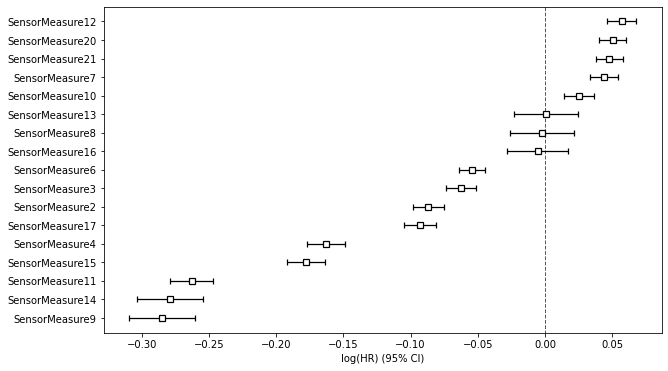

In [101]:
plt.subplots(figsize = (10, 6))
cph.plot()

## Random Forest Regressor

In [119]:
rf_train_df = train_data_df.copy()
rf_test_df = test_data_df.copy()
rf_train_labels_df = train_labels_df.copy()
rf_test_labels_df = test_labels_df.copy()

rf_train_df.drop(columns=['OpSet1', 'OpSet2', 'OpSet3'], inplace=True)
rf_train_df.drop(columns=['SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19'], inplace=True)
rf_test_df.drop(columns=['OpSet1', 'OpSet2', 'OpSet3'], inplace=True)
rf_test_df.drop(columns=['SensorMeasure1', 'SensorMeasure5', 'SensorMeasure10', 'SensorMeasure16', 'SensorMeasure18', 'SensorMeasure19'], inplace=True)

rf_train = rf_train_df.values
rf_test = rf_test_df.values
rf_train_labels = rf_train_labels_df.values.squeeze()
rf_test_labels = rf_test_labels_df.values.squeeze()

In [131]:
rf_test_at_break_df = rf_test_df.groupby('ID').last().reset_index()
rf_test_at_break = rf_test_at_break_df.values
rf_test_labels_at_break = test_labels_at_break_df.values[:, 0]

In [193]:
rf = make_pipeline(StandardScaler(), RandomForestRegressor(n_estimators = 1000, max_features = "sqrt", random_state = 42, max_depth=8, min_samples_leaf=50))
rf.fit(rf_train, rf_train_labels)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=8, max_features='sqrt',
                                       min_samples_leaf=50, n_estimators=1000,
                                       random_state=42))])

In [196]:
predictions_rf = rf.predict(rf_test_at_break).round()

rmse = np.sqrt(mean_squared_error(rf_test_labels_at_break, predictions_rf))
print("RMSE: {:.4f}".format(rmse))  

RMSE: 29.8551


## Gradient Boosting Regressor

In [191]:
gb = make_pipeline(StandardScaler(), GradientBoostingRegressor())
gb.fit(rf_train, rf_train_labels)  

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('gradientboostingregressor', GradientBoostingRegressor())])

In [192]:
predictions_gb = gb.predict(rf_test_at_break).round()

rmse = np.sqrt(mean_squared_error(rf_test_labels_at_break, predictions_gb))
print("RMSE: {:.4f}".format(rmse))  

RMSE: 32.9347


## Support Vector Regressor

In [197]:
svmr = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
svmr.fit(rf_train, rf_train_labels)

In [199]:
predictions_svmr = svmr.predict(rf_test_at_break).round()
rmse = np.sqrt(mean_squared_error(rf_test_labels_at_break, predictions_svmr))
print("RMSE: {:.4f}".format(rmse))  

RMSE: 33.3251
